In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=100

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)
#     print(label_batch.numpy())

(256, 256, 3)


# Visualize the image

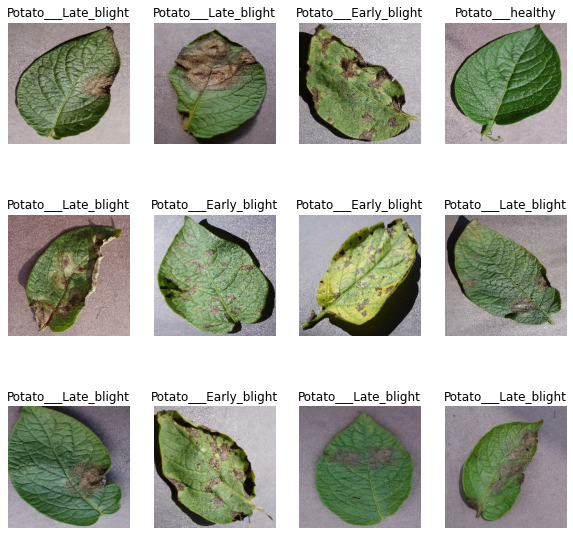

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Splitting the dataset

In [8]:
# 80% ==> training
# 20% ==> 10% validation, 10% testing

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
# cache stores the image in the cache so when nexttime the image is called it is called faster
#prefetch uses cpu when gpu is busy training (for improving the performance)
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing The images

In [20]:
resize_and_rescale=tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),     
 layers.experimental.preprocessing.Rescaling(1.0/255)   
])

# DATA AUGMENTATION

In [21]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),     
 layers.experimental.preprocessing.RandomRotation(0.2),   
])

# Building the model ie CNN

In [22]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [24]:
model.compile(
 optimizer='adam',
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
 metrics=['accuracy']   
)

In [25]:
history=model.fit(
  train_ds,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  verbose=1,
  validation_data=val_ds
)

Epoch 1/100
54/54 [==============================] - 53s 883ms/step - loss: 0.8851 - accuracy: 0.4705 - val_loss: 0.8140 - val_accuracy: 0.5156
Epoch 2/100
54/54 [==============================] - 45s 829ms/step - loss: 0.7990 - accuracy: 0.5770 - val_loss: 0.6441 - val_accuracy: 0.7344
Epoch 3/100
54/54 [==============================] - 45s 832ms/step - loss: 0.5882 - accuracy: 0.7240 - val_loss: 0.4462 - val_accuracy: 0.8594
Epoch 4/100
54/54 [==============================] - 47s 865ms/step - loss: 0.4719 - accuracy: 0.8096 - val_loss: 0.4065 - val_accuracy: 0.8021
Epoch 5/100
54/54 [==============================] - 45s 838ms/step - loss: 0.2858 - accuracy: 0.8976 - val_loss: 0.1809 - val_accuracy: 0.9271
Epoch 6/100
54/54 [==============================] - 45s 840ms/step - loss: 0.1954 - accuracy: 0.9277 - val_loss: 0.1605 - val_accuracy: 0.9479
Epoch 7/100
54/54 [==============================] - 45s 843ms/step - loss: 0.1652 - accuracy: 0.9381 - val_loss: 0.1703 - val_accuracy:

Epoch 41/100
54/54 [==============================] - 45s 835ms/step - loss: 0.0092 - accuracy: 0.9959 - val_loss: 0.0306 - val_accuracy: 0.9844
Epoch 42/100
54/54 [==============================] - 45s 834ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.1605 - val_accuracy: 0.9531
Epoch 43/100
54/54 [==============================] - 45s 837ms/step - loss: 0.0283 - accuracy: 0.9884 - val_loss: 0.1172 - val_accuracy: 0.9531
Epoch 44/100
54/54 [==============================] - 45s 833ms/step - loss: 0.0265 - accuracy: 0.9907 - val_loss: 0.0593 - val_accuracy: 0.9844
Epoch 45/100
54/54 [==============================] - 45s 836ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.0869 - val_accuracy: 0.9740
Epoch 46/100
54/54 [==============================] - 45s 831ms/step - loss: 0.0200 - accuracy: 0.9925 - val_loss: 0.9225 - val_accuracy: 0.8594
Epoch 47/100
54/54 [==============================] - 45s 837ms/step - loss: 0.0365 - accuracy: 0.9855 - val_loss: 0.0244 - val_ac

54/54 [==============================] - 45s 828ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0349 - val_accuracy: 0.9948
Epoch 98/100
54/54 [==============================] - 45s 830ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0734 - val_accuracy: 0.9792
Epoch 99/100
54/54 [==============================] - 45s 829ms/step - loss: 0.0173 - accuracy: 0.9936 - val_loss: 0.0616 - val_accuracy: 0.9844
Epoch 100/100
54/54 [==============================] - 45s 831ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0879 - val_accuracy: 0.9792


In [26]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 178ms/step - loss: 0.0664 - accuracy: 0.9922


In [27]:
scores

[0.06635139882564545, 0.9921875]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
len(history.history['accuracy'])

100

In [32]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

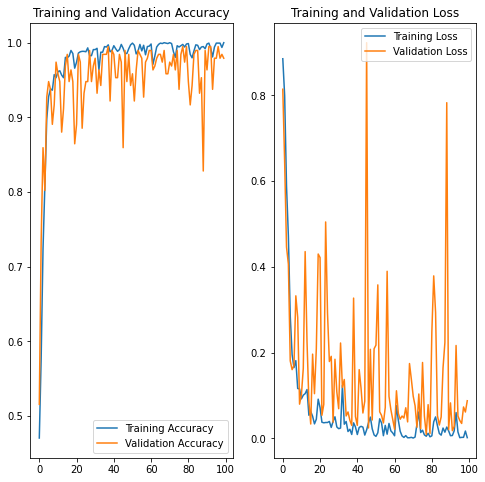

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: Potato___Late_blight
1/1 [==============================] - 0s 288ms/step
Predicted Label: Potato___Late_blight


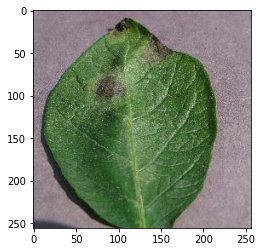

In [34]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])]) #to predict all we have to remove argmax so it will predict all probabilities for all classes

In [35]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)#create a batch
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

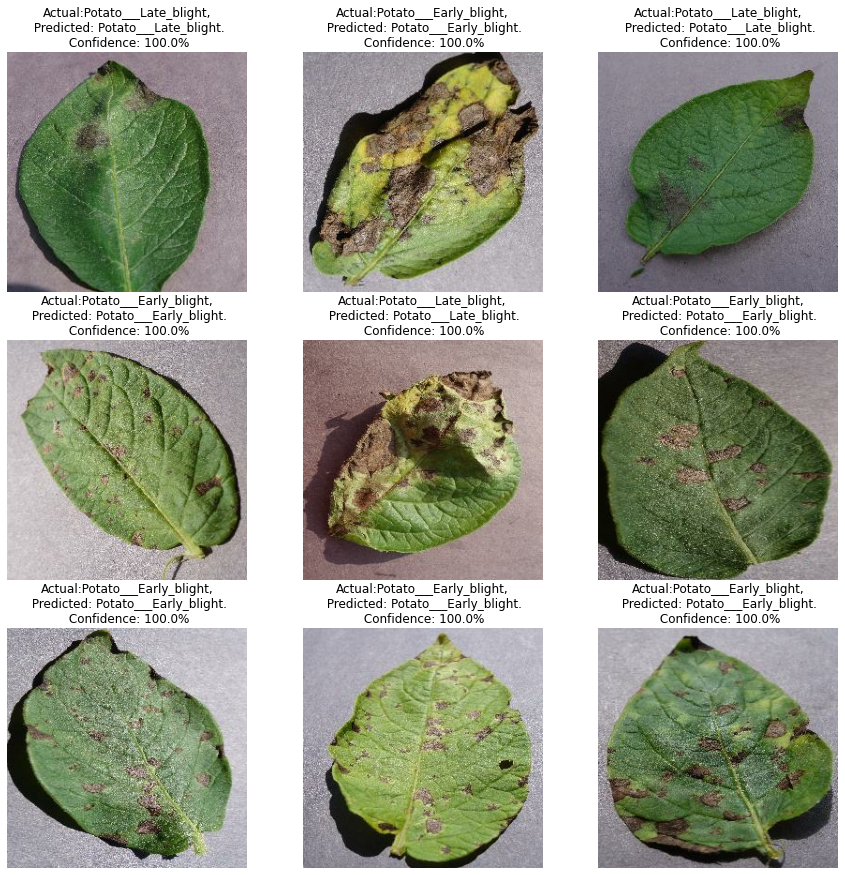

In [36]:
tf.keras.utils.disable_interactive_logging()
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
import os
# model_version=max([int(i) for i in os.listdir("../models")]+[0])+1
model.save(f"../models/4")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'